# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [24]:
import pandas as pd
import os
from os.path import isfile, join
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms


BASE = "./Dataset"
#BASE = "gdrive/MyDrive/Dataset"
cloth_folder = os.path.join(BASE, "Cloth Mask")
n95_folder = os.path.join(BASE, "N95")
n95valve_folder = os.path.join(BASE, "N95 mask with valve")
surgical_folder = os.path.join(BASE, "Surgical Mask")
without_mask_folder = os.path.join(BASE, "No Mask")
root_folder = os.path.join(BASE, "./")



In [25]:
# create directory
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

model_path = os.path.join(root_folder, 'model/AI.pth')
make_dir(model_path)

# predefined classes
classes = {
    "cloth": 0,
    "n95": 1,
    "n95valve": 2,
    "surgical": 3,
    "without_mask": 4
}


In [26]:
class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, images, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        self.dataset = images[int(indexes[0]):int(indexes[1])]
        
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target']



In [7]:

def load_images():
  dat = []
  cnt = 0
  for filename in os.listdir(cloth_folder):
    sample = {}
    img = Image.open(os.path.join(cloth_folder, filename)).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['cloth']
    dat.append(sample)
    cnt += 1
    if cnt % 50 == 0:
      print(cnt)
    #img.close()

  for filename in os.listdir(n95_folder):
    sample = {}
    img = Image.open(os.path.join(n95_folder, filename)).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['n95']
    dat.append(sample)
    cnt += 1
    if cnt % 50 == 0:
      print(cnt)
    #img.close()

  for filename in os.listdir(n95valve_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(n95valve_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['n95valve']
        dat.append(sample)
        cnt += 1
        if cnt % 50 == 0:
          print(cnt)
        #img.close()
    except:
        continue

  for filename in os.listdir(surgical_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(surgical_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['surgical']
        dat.append(sample)
        cnt += 1
        if cnt % 50 == 0:
          print(cnt)
        #img.close()
    except:
        continue

  for filename in os.listdir(without_mask_folder):
    try:
        sample = {}
        img = Image.open(os.path.join(without_mask_folder, filename)).convert('RGB')
        sample['image'] = img
        sample['target'] = classes['without_mask']
        dat.append(sample)
        cnt += 1
        if cnt % 50 == 0:
          print(cnt)
        #img.close()
    except:
        continue

  return dat



In [ ]:
'''
import glob
def load_images():
  dat = []
  cnt = 0
  for f in glob.iglob(cloth_folder + '/*'):
    sample = {}
    img = Image.open(f).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['cloth']
    dat.append(sample)
    cnt += 1
    if cnt % 50 == 0:
      print(cnt)
    #img.close()

  for f in glob.iglob(n95_folder + '/*'):
    sample = {}
    img = Image.open(f).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['n95']
    dat.append(sample)
    cnt += 1
    if cnt % 50 == 0:
      print(cnt)
    #img.close()

  for f in glob.iglob(n95valve_folder + '/*'):
    sample = {}
    img = Image.open(f).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['n95valve']
    dat.append(sample)
    cnt += 1
    if cnt % 50 == 0:
      print(cnt)
    #img.close()

  for f in glob.iglob(surgical_folder + '/*'):
    sample = {}
    img = Image.open(f).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['surgical']
    dat.append(sample)
    cnt += 1
    if cnt % 50 == 0:
      print(cnt)
    #img.close()

  cnt = 0
  for f in glob.iglob(without_mask_folder + '/*'):
    sample = {}
    img = Image.open(f).convert('RGB')
    sample['image'] = img
    sample['target'] = classes['without_mask']
    dat.append(sample)
    cnt += 1
    if cnt == 400:
      break
    #img.close()

  return dat
'''

In [27]:

train_split_percentage = 0.75
val_split_percentage = 0.15
test_split_percentage = 0.1
#size_of_the_dataset = int(data_df.shape[0])

#load images into memory
images = load_images()
random.shuffle(images)
size_of_the_dataset = len(images)
print("size_of_the_dataset", size_of_the_dataset)


batch_size = 25
num_of_classes = len(classes.keys())

# indexes = list(range(size_of_the_dataset))
# random.shuffle(indexes)


# train_indexes = indexes[:int(train_split_percentage*len(indexes))]
# val_indexes = indexes[int(train_split_percentage*len(indexes)) : int((train_split_percentage + val_split_percentage)*len(indexes))]
# test_indexes = indexes[int((train_split_percentage + val_split_percentage)*len(indexes)):]

train_indexes = [0, train_split_percentage * size_of_the_dataset]
val_indexes = [train_split_percentage * size_of_the_dataset, (train_split_percentage + val_split_percentage) * size_of_the_dataset]
test_indexes = [(train_split_percentage + val_split_percentage) * size_of_the_dataset, size_of_the_dataset]



print(f"Effective train split = {train_indexes[0]} to {train_indexes[1]}")
print(f"Effective val split = {val_indexes[0]} to {val_indexes[1]}")
print(f"Effective test split = {test_indexes[0]} to {test_indexes[1]}")


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
size_of_the_dataset 2065
Effective train split = 0 to 1548.75
Effective val split = 1548.75 to 1858.5
Effective test split = 1858.5 to 2065


In [28]:

transform = transforms.Compose(
    [transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])

In [29]:
# 0 for train, 1 for validation, 2 for test
print("Loading training set")
train_dataset = FaceMaskDataset(images, train_indexes, conversion=transform)

print("Loading validation set")
val_dataset = FaceMaskDataset(images, val_indexes, conversion=transform)

print("Train Dataset length ", len(train_dataset))
print("Validation Dataset length ", len(val_dataset))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Loading training set
Loading validation set
Train Dataset length  1548
Validation Dataset length  310


In [11]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(246016, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, num_of_classes),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [31]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            images, labels = batch
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [32]:

model = CNN()
model = model.to(device)

In [ ]:
torch.cuda.empty_cache()

In [33]:
history = fit(25, 0.0001, model, train_loader, val_loader, torch.optim.Adam)

#torch.save(model, model_path)

Epoch [1], train_loss: 2.1634, val_loss: 1.3191, val_acc: 0.4385
Epoch [2], train_loss: 1.0094, val_loss: 1.1510, val_acc: 0.5446
Epoch [3], train_loss: 0.6336, val_loss: 1.1975, val_acc: 0.5415
Epoch [4], train_loss: 0.3839, val_loss: 1.3340, val_acc: 0.5400
Epoch [5], train_loss: 0.1924, val_loss: 1.4127, val_acc: 0.5462
Epoch [6], train_loss: 0.0878, val_loss: 1.5757, val_acc: 0.5492


KeyboardInterrupt: 

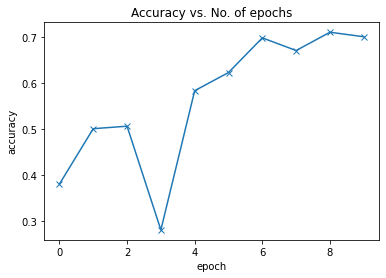

In [17]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(history)

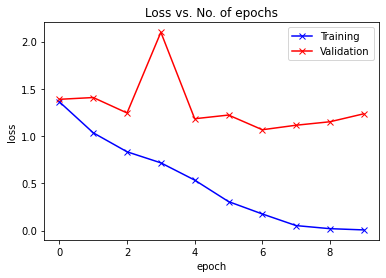

In [18]:

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)


In [19]:
test_dataset = FaceMaskDataset(images, test_indexes, conversion=transform)
print("Loading test set")
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

Loading test set


In [20]:
y_true = torch.tensor([])
y_true = y_true.to(device)
y_preds = torch.tensor([])
y_preds = y_preds.to(device)

# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true = torch.cat((y_true, labels))
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_preds = torch.cat((y_preds, predicted))
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

y_true = y_true.to('cpu')
y_preds = y_preds.to('cpu')

Test Accuracy of the model: 74.03100775193798 %


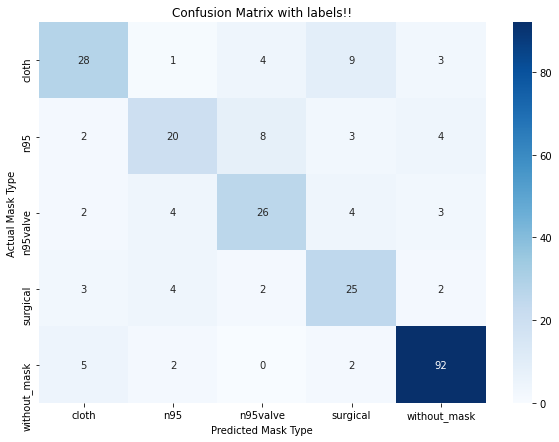

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# show confusion matrix
def show_confusion_matrix(y_true, y_preds):
    matrix = confusion_matrix(y_true, y_preds)
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix with labels!!');
    ax.set_xlabel('Predicted Mask Type')
    ax.set_ylabel('Actual Mask Type')
    ax.xaxis.set_ticklabels([i for i in classes.keys()])
    ax.yaxis.set_ticklabels([i for i in classes.keys()])
    plt.show()

show_confusion_matrix(y_true, y_preds)


In [22]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_true, y_preds)
print(classification_report(y_true,y_preds))

              precision    recall  f1-score   support

         0.0       0.70      0.62      0.66        45
         1.0       0.65      0.54      0.59        37
         2.0       0.65      0.67      0.66        39
         3.0       0.58      0.69      0.63        36
         4.0       0.88      0.91      0.90       101

    accuracy                           0.74       258
   macro avg       0.69      0.69      0.69       258
weighted avg       0.74      0.74      0.74       258



In [23]:
def label_to_classname(label):
  for classname in classes.keys():
    if classes[classname] == label:
      return classname
  return 'NULL'


In [ ]:
# Put new images at the 'test' directory to classify them
new_images_path = os.path.join(root_folder, "./test")

# get new images
new_images = os.listdir(new_images_path)

with torch.no_grad():
    for image in new_images:
      file_name = image
      image = transform(Image.open(os.path.join(new_images_path, image)).convert('RGB'))
      # image = image.unsqueeze(1)
      image = image.unsqueeze(0)
      image = image.to(device)
      labels = model(image)
      _, predicted = torch.max(labels.data, 1)
      print(f'{file_name} file is {label_to_classname(predicted[0])}')